# Libraries

In [1]:
import os

# go up one directory
os.chdir("..")

import pandas as pd 
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from functions import cosmic_val
from functions.graph_tools import *
from models.aenmf import *
from functions import data_handling as dh
import torch.optim as optim
import torch.nn as nn

# set seed
np.random.seed(30)
torch.manual_seed(30)

# Data

In [2]:
data_path = "data/catalogues_Ovary_SBS.tsv"
cosmic_path = "data/COSMIC_v3.4_SBS_GRCh37.txt"
output_folder = "data/processed"
output_filename = "Ordered_Ovary_SBS.csv"
ordered_data_path = os.path.join(output_folder, output_filename)

In [3]:
dh.load_preprocess_data(data_path, cosmic_path, sep1 = "\t", sep2 = "\t", output_folder = output_folder, output_filename = output_filename)

Data already exists in  data/processed/Ordered_Ovary_SBS.csv


In [4]:
# load data
data = pd.read_csv(ordered_data_path, index_col = 0)
cosmic = pd.read_csv(cosmic_path, sep = "\t", index_col = 0)

In [5]:
LATENT_DIM = 4
TOLERANCE = 1e-10
MAX_ITERATIONS = 100_000_000

In [6]:
losses_train = []
losses_test = []
signatures = []
iterations = 30

for i in tqdm(range(iterations)):
    # Train-test split (here it makes sense, we are working with AE)
    train, test = train_test_split(data.T, test_size = 0.2)

    # Initializing AENMF model
    aenmf_model = aenmf(input_dim = train.shape[1],
                              latent_dim = LATENT_DIM)
    

    # Training AENMF
    aenmf_mod,training_loss_aenmf, signatures_aenmf, exposures_aenmf = train_aenmf( 
                                                model = aenmf_model,
                                                training_data = train,
                                                optimizer = optim.Adam(aenmf_model.parameters(), lr=1e-3),
                                                tol = TOLERANCE,
                                                relative_tol = False,
                                                max_iter = MAX_ITERATIONS)
    
    # Check that test.shape[1] == train.shape[1]

    if(test.shape[1] != train.shape[1]):
        raise ValueError("Test shape is different from train shape. Check the code.")


    test_model = aenmf(input_dim = test.shape[1],
                              latent_dim = LATENT_DIM)
    
    print("Signature shape:", signatures_aenmf.shape)
    print("Test input dimension:", test.shape[1])


    
    test_model.load_custom_weights(signature = signatures_aenmf)
    test_model.freeze_encoder()

    _, test_loss, _, _ = train_aenmf(model = test_model,
                                    training_data = test,
                                    optimizer = optim.Adam(test_model.parameters(), lr=1e-3),
                                    tol = TOLERANCE,
                                    relative_tol = False,
                                    max_iter = MAX_ITERATIONS)


    
    # Calculating signatures and exposures for NMF
    epsilon = 1e-8
    diagonals_aenmf = signatures_aenmf.sum(axis=0)
    signatures_aenmf = (signatures_aenmf) @ np.diag(1 / (diagonals_aenmf + epsilon))
    # signatures_aenmf = (signatures_aenmf) @ np.diag(1 / diagonals_aenmf)

    losses_test.append(test_loss[-1])
    losses_train.append(training_loss_aenmf[-1])
    signatures.append(signatures_aenmf)



  0%|          | 0/30 [00:00<?, ?it/s]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


  3%|▎         | 1/30 [00:27<13:08, 27.18s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


  7%|▋         | 2/30 [00:47<10:55, 23.42s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 10%|█         | 3/30 [01:10<10:19, 22.95s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 13%|█▎        | 4/30 [01:24<08:28, 19.56s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 17%|█▋        | 5/30 [01:43<07:59, 19.17s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 20%|██        | 6/30 [01:59<07:20, 18.36s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 23%|██▎       | 7/30 [02:20<07:16, 18.96s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 27%|██▋       | 8/30 [02:39<07:00, 19.10s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 30%|███       | 9/30 [02:57<06:32, 18.71s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 33%|███▎      | 10/30 [03:20<06:43, 20.18s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 37%|███▋      | 11/30 [03:37<06:03, 19.15s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 40%|████      | 12/30 [03:52<05:20, 17.82s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 43%|████▎     | 13/30 [04:12<05:13, 18.43s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 47%|████▋     | 14/30 [04:27<04:38, 17.41s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 50%|█████     | 15/30 [04:41<04:08, 16.55s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 53%|█████▎    | 16/30 [04:51<03:20, 14.33s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 57%|█████▋    | 17/30 [05:12<03:34, 16.49s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 60%|██████    | 18/30 [05:27<03:13, 16.13s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 63%|██████▎   | 19/30 [05:45<03:01, 16.48s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 67%|██████▋   | 20/30 [06:00<02:41, 16.19s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 70%|███████   | 21/30 [06:13<02:16, 15.16s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 73%|███████▎  | 22/30 [06:27<01:57, 14.74s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 77%|███████▋  | 23/30 [06:39<01:37, 13.98s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 80%|████████  | 24/30 [07:01<01:37, 16.31s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 83%|████████▎ | 25/30 [07:16<01:19, 15.90s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 87%|████████▋ | 26/30 [07:33<01:05, 16.30s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 90%|█████████ | 27/30 [07:46<00:45, 15.26s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 93%|█████████▎| 28/30 [08:01<00:30, 15.36s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


 97%|█████████▋| 29/30 [08:15<00:14, 14.75s/it]

Signature shape: torch.Size([96, 4])
Test input dimension: 96


100%|██████████| 30/30 [08:27<00:00, 16.92s/it]


In [7]:
print("Losses train: ", np.mean(losses_train))
print("Losses test: ", np.mean(losses_test))

Losses train:  17747.223404947916
Losses test:  9934.596752929687


In [8]:
all_signatures = np.hstack(signatures)

In [9]:
print(all_signatures.shape)

(96, 120)


In [10]:
pam = KMedoids(n_clusters = LATENT_DIM, metric='cosine').fit(all_signatures.T)
labels = pam.labels_
medoid_indices = pam.medoid_indices_
consensus_signatures = all_signatures[:, medoid_indices]

In [11]:
matched_signatures, mean_similarity = cosmic_val.compute_match(consensus_signatures, cosmic, index = 0)

In [12]:
print(matched_signatures.head())
print("\nMean similarity of the matched signatures: ", mean_similarity)

   Extracted_0  True_0  Similarity_0
0            0   SBS44      0.863949
1            1   SBS13      0.730765
2            2   SBS52      0.794036
3            3  SBS10a      0.928761

Mean similarity of the matched signatures:  0.8293775281388693


In [13]:
all_matches = cosmic_val.compute_all_matches(all_signatures, cosmic, n_runs = 4)

In [14]:
all_matches

,True_0,Similarity_0,True_1,Similarity_1,True_2,Similarity_2,True_3,Similarity_3,True_4,Similarity_4,...,True_25,Similarity_25,True_26,Similarity_26,True_27,Similarity_27,True_28,Similarity_28,True_29,Similarity_29
0,SBS44,0.834323,SBS17b,0.935988,SBS13,0.723834,SBS6,0.941465,SBS5,0.599965,...,SBS13,0.728878,SBS5,0.598289,SBS6,0.936344,SBS6,0.843372,SBS13,0.758058
1,SBS52,0.789919,SBS10c,0.745549,SBS10a,0.932417,SBS10a,0.928844,SBS44,0.833367,...,SBS6,0.941261,SBS10a,0.932406,SBS13,0.734766,SBS5,0.594465,SBS40c,0.780887
2,SBS5,0.605439,SBS13,0.752413,SBS5,0.594883,SBS26,0.772106,SBS10a,0.932462,...,SBS44,0.767205,SBS44,0.820388,SBS10a,0.928735,SBS10a,0.932354,SBS10a,0.928805
3,SBS10a,0.923687,SBS44,0.843583,SBS6,0.828558,SBS13,0.758407,SBS13,0.729669,...,SBS10a,0.928756,SBS13,0.751703,SBS44,0.783927,SBS13,0.726311,SBS6,0.942338


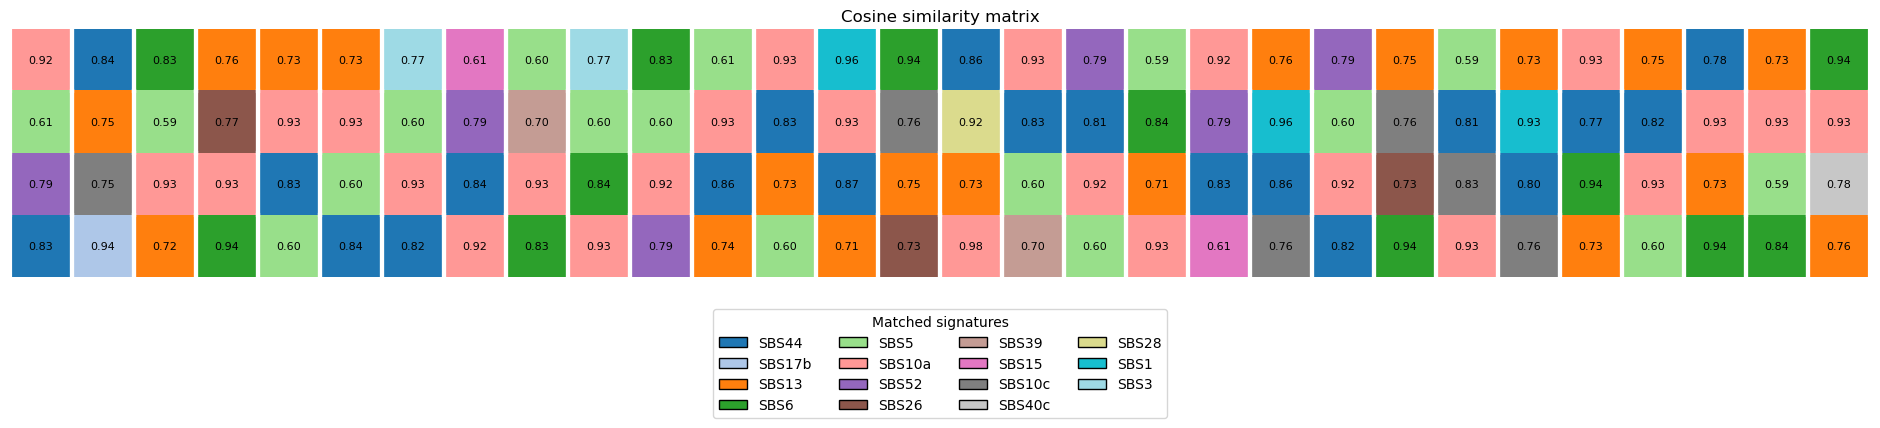

In [15]:
plot_cosine_similarity_matrix(all_matches, title = "Cosine similarity matrix", figsize=(24, 12), legend_colums=4, palette='tab20')

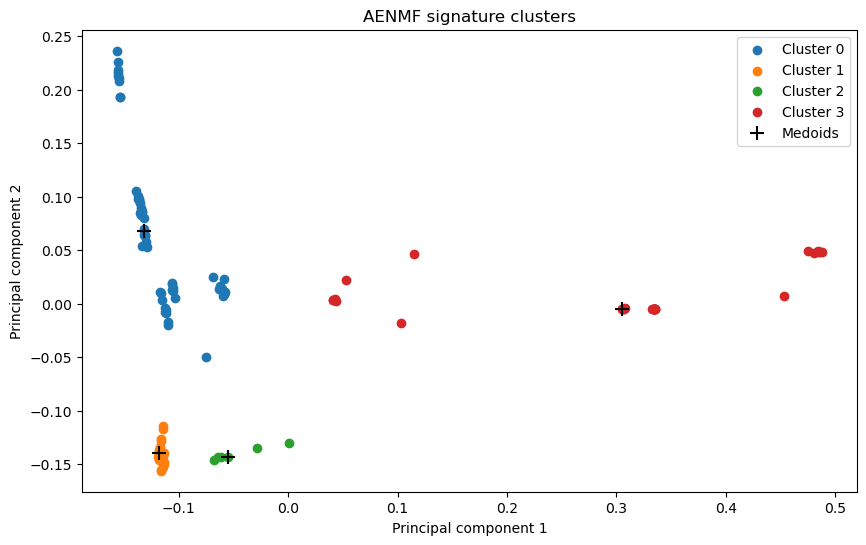

In [16]:
reduced_signatures = PCA(n_components=2).fit_transform(all_signatures.T)
plot_clusters(reduced_signatures, labels, medoid_indices, 4, "AENMF signature clusters")

In [17]:
df_consensus = pd.DataFrame(consensus_signatures, index = data.index)

In [18]:
df_consensus

,0,1,2,3
Type,,,,
A[C>A]A,0.005132,0.028709,0.007791,0.001743
A[C>A]C,0.003743,0.020973,0.012027,0.003052
A[C>A]G,0.000510,0.003683,0.001656,0.000390
A[C>A]T,0.004260,0.017612,0.053471,0.015009
A[C>G]A,0.003287,0.016151,0.001395,0.000368
...,...,...,...,...
T[T>C]T,0.049852,0.000000,0.000000,0.009735
T[T>G]A,0.000000,0.002100,0.046810,0.020484
T[T>G]C,0.000328,0.002475,0.005453,0.008123


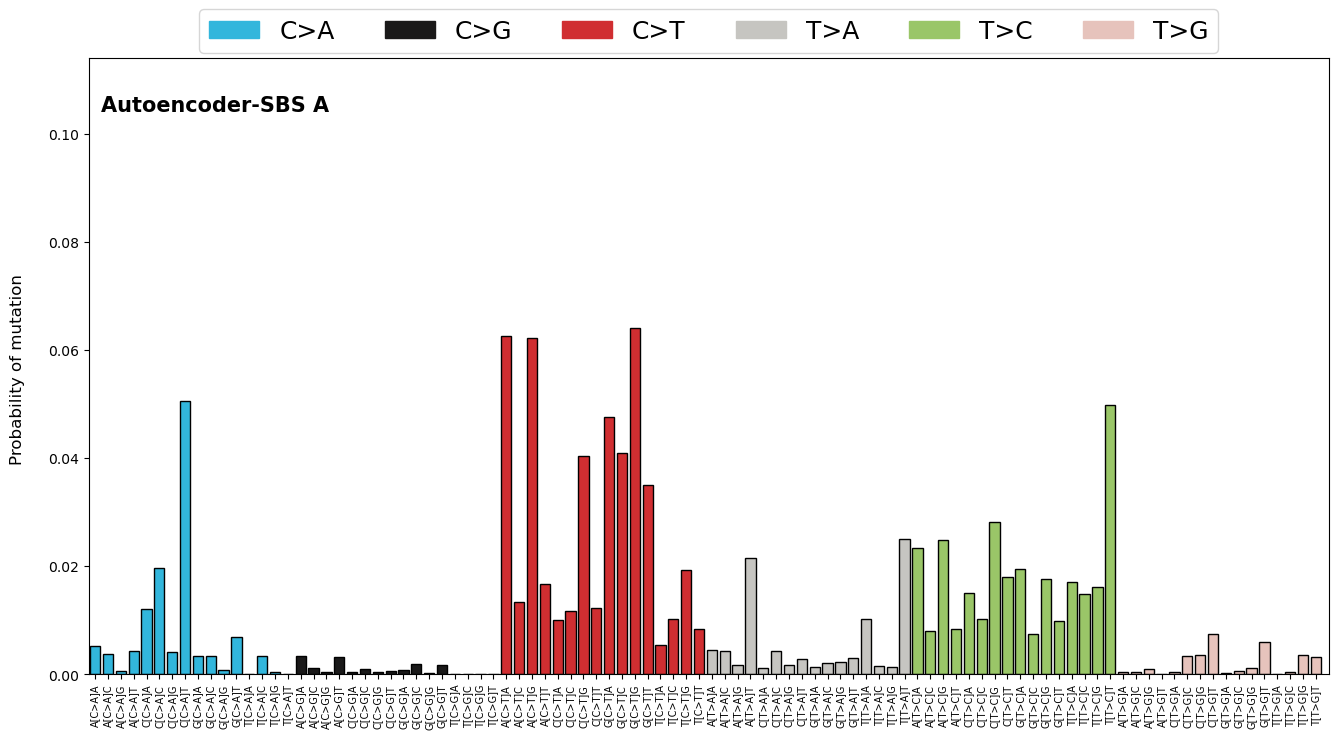

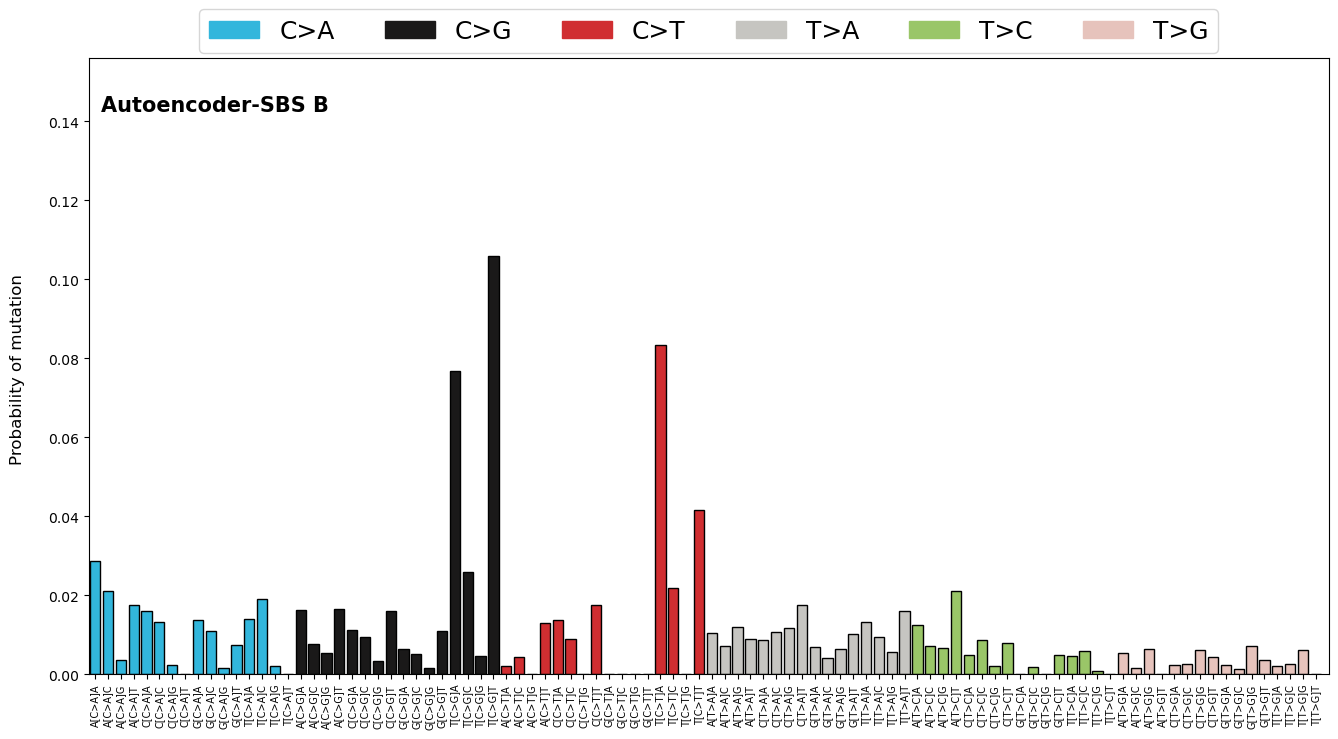

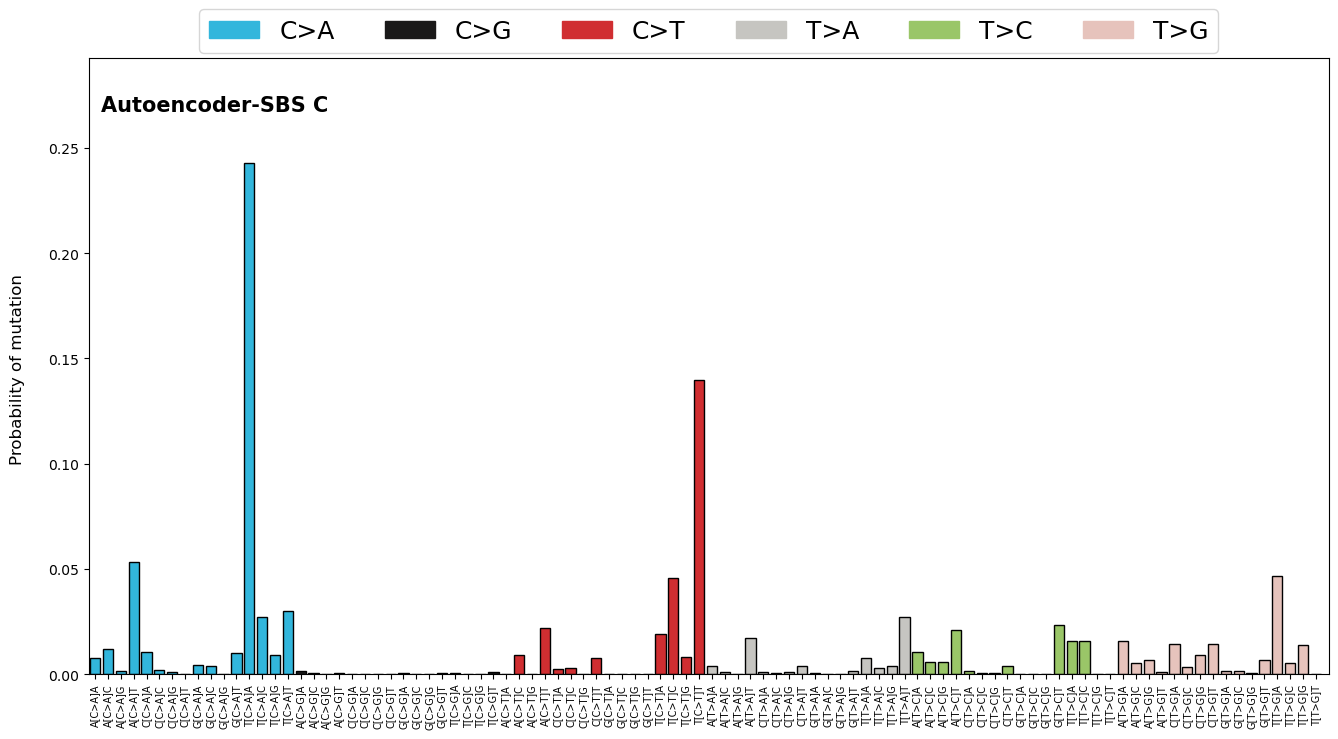

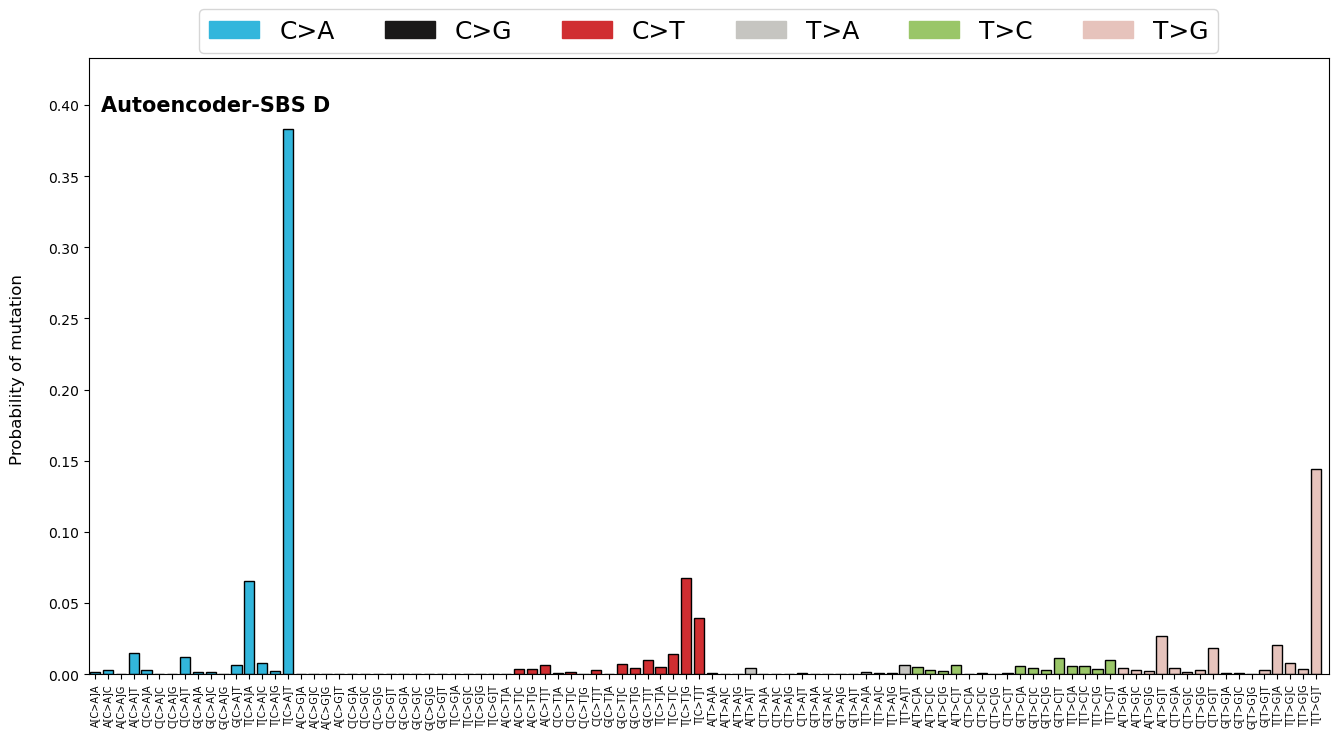

In [19]:
plot_signature(df_consensus)